In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy as sp
import networkx as nx

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from collections import defaultdict
from scipy.spatial import distance

import random

%matplotlib inline
#%load_ext line_profiler

from matplotlib import rc
params = {'text.usetex': False, 'mathtext.fontset': 'stixsans', 'axes.linewidth': 2}
plt.rcParams.update(params)
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 2

# open Qs (TC)
* world coordinates solve the maze
    * how can we use egocentric coordinates?
    * can world coord be used to avoid problems faster?
* what types of problems would use egocentric vs world coordinates
    * egocentric - bootstraping
        * understanding similarity between different MDPs (contexts)
    * world coordinates - model based
        * mapping out environments

# simple grid world
functions to be defined:
* set initial and end position
* generate set of graphs with at least one path from inital to end pos
* take that set of graphs and generate graphs with rewards and punishments
    * rules for (R,P):
        * only one reward
        * maximum M punishments
        * at least one path without punishment

# Successor representation
* do the same experiments but now thinking about the SR
* calculate those matrices and then plot the eigenvectors

In [2]:
def plot_graph_matrix(G):
    plt.imshow(nx.to_numpy_matrix(G))
    
def init_state(G):
    return list(G.nodes)[np.random.randint(len(G.nodes))]

def draw_graph(G, fig_size):
    plt.figure(figsize=(fig_size[0], fig_size[1]))
    pos = {(x,y):(y,-x) for x,y in G.nodes()}
    nx.draw(G, pos=pos, 
            node_color='k', 
            with_labels=False,
            node_size=300)

In [3]:
def get_next_state(G, current_state, action):
    # given an initial state, outputs the next state after action is taken
    # need to insert rewards/punishments (probably should be a data structure)
    
    # get all edges of current_state node
    neigh_edges = G.edges(current_state)
    
    valid_state = False
    valid_transition = False
    
    if action == 0: #UP
        next_state = (current_state[0]-1, current_state[1])
    if action == 1: #DOWN
        next_state = (current_state[0]+1, current_state[1])    
    if action == 2: #LEFT
        next_state = (current_state[0], current_state[1]-1)    
    if action == 3: #RIGHT
        next_state = (current_state[0], current_state[1]+1)
        
    # check if next state is valid
    
    for node in G.nodes:
        if next_state == node:
            valid_state = True
    
    for edge in neigh_edges:
        if next_state == edge[1]:
            valid_transition = True
    
    if (valid_state & valid_transition):
        return next_state
    else:
        return current_state

# generate valid graphs
Rules:
* no isolated states - complete graph (formal definition)
* start and end state conditions
    * at least one path between start and end state
        * at least one path without punishments
        * this implies that we need to have at least 2 different paths for rewards

# generate a set of connected graphs with some edges removed

In [4]:
def remove_edges(G, n_edges):
    
    # generates a graph with n_edges removed

    for i in range(n_edges):
        n_total_edges = len(list(G.edges))
        random_edge = list(G.edges)[np.random.randint(n_total_edges)]
        G.remove_edge(random_edge[0],random_edge[1])
        
    return G

In [5]:
def generate_connected_graphs(grid_size, n_graphs, n_tries, n_edges_removed):
    
    c = 0
    g_list = []
    for n in range(n_tries):
        g = nx.grid_2d_graph(grid_size, grid_size)
        g = remove_edges(g, n_edges_removed)
        #print(nx.is_connected(g))
        if nx.is_connected(g):
            g_list.append(g)
            c +=1
        if c == n_graphs:
            break
            
    return g_list

In [6]:
grid_size = 5
n_graphs = 3
n_tries = 1000
n_edges = 15
f = nx.grid_2d_graph(grid_size,grid_size)
g_list = generate_connected_graphs(grid_size, n_graphs, n_tries, n_edges)
print(len(g_list))
print(len(list(f.edges)))
for e in g_list:
    print(len(list(e.edges)))

3
40
25
25
25


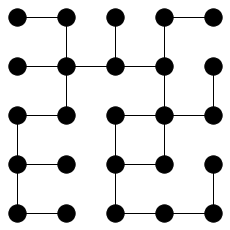

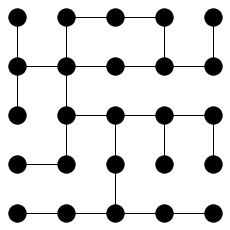

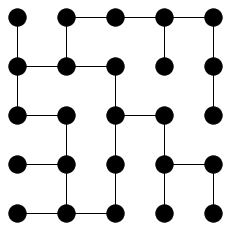

In [7]:
for e in g_list:
    plt.figure(figsize=(3,3))
    pos = {(x,y):(y,-x) for x,y in e.nodes()}
    nx.draw(e, pos=pos, 
            node_color='k', 
            with_labels=False,
            node_size=300)
    plt.show()

# pass graphs through node2vec

In [8]:
class node2vec():
    
    def __init__(self, graph, max_walks, walk_len):

        self.graph = graph
        
        probs = defaultdict(dict)
        for node in self.graph.nodes():
            probs[node]['probabilities'] = dict()
            
        self.probs = probs
        
        # these two parameters bias the exploration towards
        # depth or breadth
        
        self.p = 1 # return parameter - low value of p -> BFS
        self.q = 0.8 # runaway parameter - low value of q -> DFS
        
        self.max_walks = max_walks
        self.walk_len = walk_len
        
        self.walks1 = []
        self.walks2 = []
    
    def compute_probabilities(self):
        # calculate the biased transition probabilities for the 
        # random walks of the graph
        
        G = self.graph
        for source_node in G.nodes():
            for current_node in G.neighbors(source_node):
                probs_ = list()
                for destination in G.neighbors(current_node):
                    
                    # these probabilities will bias the random walks
                    if source_node == destination:
                        prob_ = G[current_node][destination].get('weight',1) * (1/self.p)
                    elif destination in G.neighbors(source_node):
                        prob_ = G[current_node][destination].get('weight',1)
                    else:
                        prob_ = G[current_node][destination].get('weight',1) * (1/self.q)

                    probs_.append(prob_)

                self.probs[source_node]['probabilities'][current_node] = probs_/np.sum(probs_)
    
    def generate_random_walks(self):
        # purpose here is to define sequences of paths along the graph
        # these sequences will later on be embedded in word2vec
        
        G = self.graph
        
        walks = list()
        for start_node in G.nodes():
            for i in range(self.max_walks):
                
                walk = [start_node]
                walk_options = list(G[start_node])
                
                if len(walk_options)==0:
                    break
                    
                first_step_idx = np.random.choice(len(walk_options))
                first_step = walk_options[first_step_idx]
                walk.append(first_step)
                
                for k in range(self.walk_len-2):
                    walk_options = list(G[walk[-1]])
                    if len(walk_options)==0:
                        break
                    probabilities = self.probs[walk[-2]]['probabilities'][walk[-1]]
                    next_step_idx = np.random.choice(len(walk_options), p=probabilities)
                    next_step = walk_options[next_step_idx]
                    walk.append(next_step)
                
                walks.append(walk)
        np.random.shuffle(walks)
        walks1 = [list(map(str,walk)) for walk in walks]
        walks2 = [list(walk) for walk in walks]
        
        walks2 = np.array(walks2)
        first_node = walks2[:,0,:]
        walks_new = walks2 - first_node[:, None, :]
        walks_new = [list(map(str, tuple(walk))) for walk in walks_new]
        self.walks2 = walks_new
        
        return walks1
    
    def get_walks(self):
        
        self.compute_probabilities()
        return self.generate_random_walks()

In [9]:
g1 = generate_connected_graphs(5, 1, 10, 5)
g1 = g1[0]
n2v_g = node2vec(g1, 5, 10)

In [10]:
n2v_g.compute_probabilities()

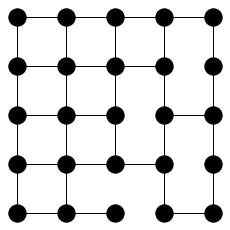

In [11]:
draw_graph(g1,[3,3])

In [12]:
walks = n2v_g.generate_random_walks()

### now try to embed the sequences with word2vec
* plot one embedding per model
* check if the same maze run different times gives similar embeddings
* is there something better than t-sne to plot the embeddings

In [13]:
model = Word2Vec(walks, vector_size=128, window=5, min_count=0, sg=1, workers=1)

In [14]:
node_embeddings = model.wv.vectors

In [15]:
tsne = TSNE(n_components=2)
node_embeddings_2d = tsne.fit_transform(node_embeddings)

In [16]:
node_embeddings_2d.shape

(25, 2)

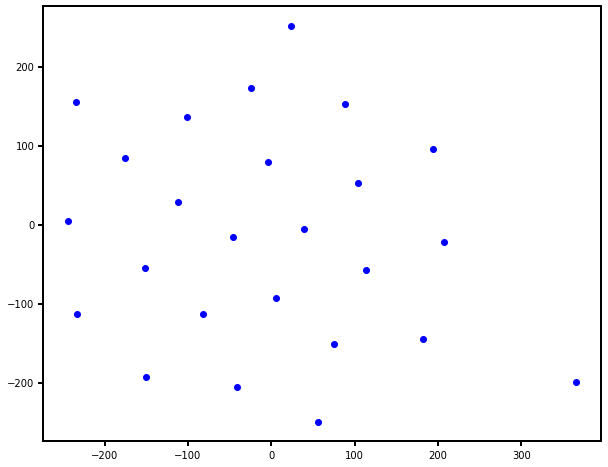

In [17]:
plt.figure(figsize=(10,8))
plt.scatter(node_embeddings_2d[:,0],
            node_embeddings_2d[:,1], c = 'Blue')
plt.show()

# embed a set of graphs

In [18]:
def paint_nodes(G, r_pos, p_pos, fig_size):
    plt.figure(figsize=(fig_size[0],fig_size[1]))
    
    nc = []
    for node in G.nodes:
        if node == r_pos:
            nc.append('g')
        if node == p_pos:
            nc.append('r')
        if node != r_pos and node != p_pos:
            nc.append('k')
    
    #del nc[-1
    
    #print(nc)
    pos = {(x,y):(y,-x) for x,y in G.nodes()}
    
    nx.draw(G, pos = pos, 
            node_color = nc, 
            with_labels = False,
            node_size=300)

In [19]:
grid_size = 5
n_graphs = 2
n_tries = 100
n_edges = 15

f = nx.grid_2d_graph(grid_size, grid_size)
g1 = generate_connected_graphs(grid_size, 1, n_tries, 0)[0]
g2 = generate_connected_graphs(grid_size, 1, n_tries, 0)[0]

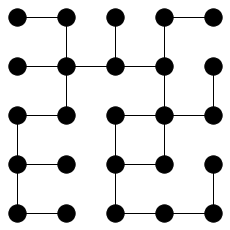

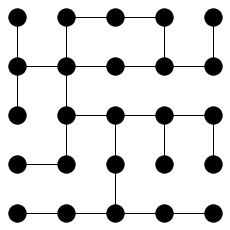

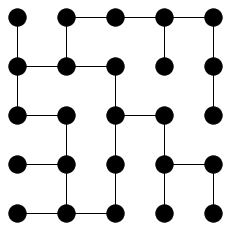

In [20]:
for g in g_list:
    draw_graph(g, [3,3])

# T-SNE
* write function to paint walks to check if they make sense
* calculate the successor features of the graph by doing random walks
    * there should be clustering and separation of the rooms

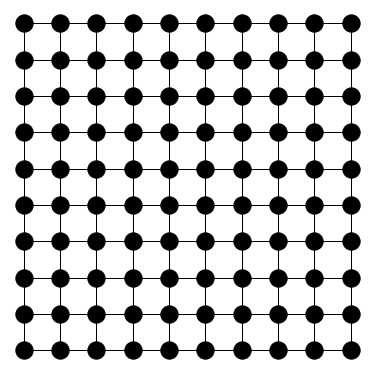

In [21]:
grid_size = 10
n_graphs = 2
n_tries = 100
n_edges = 15

f = nx.grid_2d_graph(grid_size, grid_size)
g1 = generate_connected_graphs(grid_size, 1, n_tries, 0)[0]

draw_graph(g1,[5,5])

In [22]:
def generate_4_room_maze():
    grid_size = 10
    n_graphs = 2
    n_tries = 100
    n_edges = 15

    f = nx.grid_2d_graph(grid_size, grid_size)
    g1 = generate_connected_graphs(grid_size, 1, n_tries, 0)[0]
    
    
    for i in range(grid_size):
        g1.remove_edge((4,i),(5,i))
        g1.remove_edge((i,4),(i,5))
        
    g1.add_edge((2,2),(5,2))
    g1.add_edge((2,4),(2,5))
    g1.add_edge((7,4),(7,5))
    g1.add_edge((4,7),(5,7))
    
    return g1

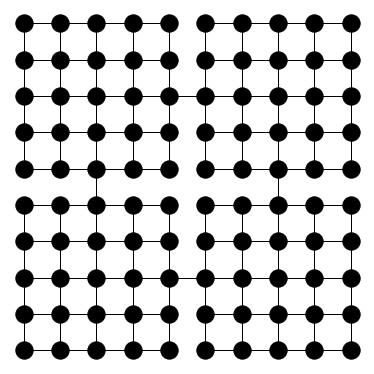

In [23]:
g4 = generate_4_room_maze()
draw_graph(g4,[5,5])

In [24]:
n2v_g = node2vec(g4, 20, 10)

In [25]:
g4_walks = n2v_g.get_walks()
w2v_m = Word2Vec(g4_walks, vector_size=50, window=10, min_count=1, sg=1, workers=1)
node_embeddings = w2v_m.wv.vectors
node_ids= w2v_m.wv.index_to_key

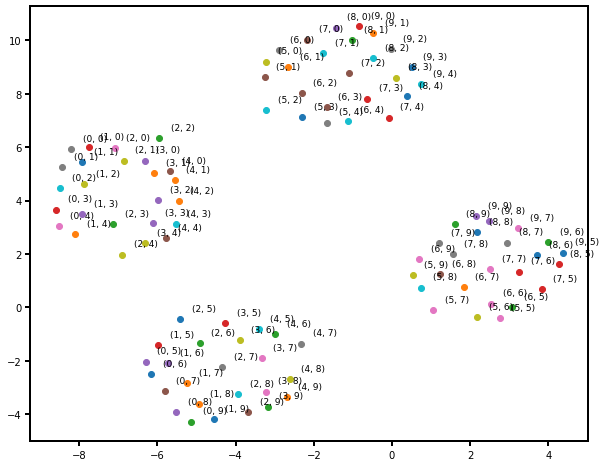

In [26]:
embs = tsne.fit_transform(node_embeddings)
plt.figure(figsize=(10,8))
for i,e in enumerate(node_ids):
    plt.scatter(embs[i,0], embs[i,1])
    plt.text(embs[i,0]+0.3, embs[i,1]+0.3, e, fontsize=9)
plt.show()

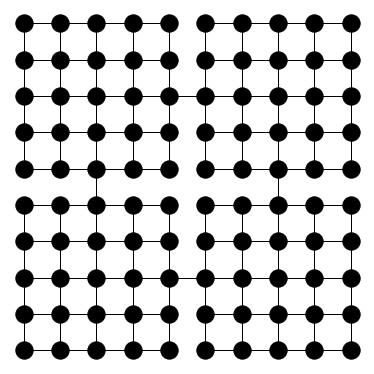

In [27]:
g3 = generate_4_room_maze()
draw_graph(g3,[5,5])

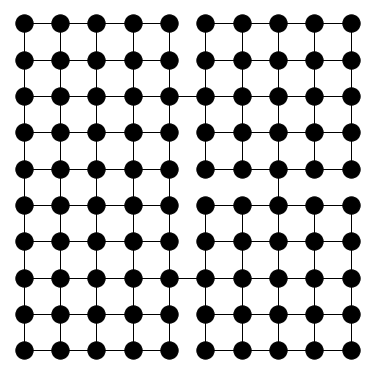

In [28]:
for i in range(5):
    g3.add_edge((4,i),(5,i))
draw_graph(g3, [5,5])

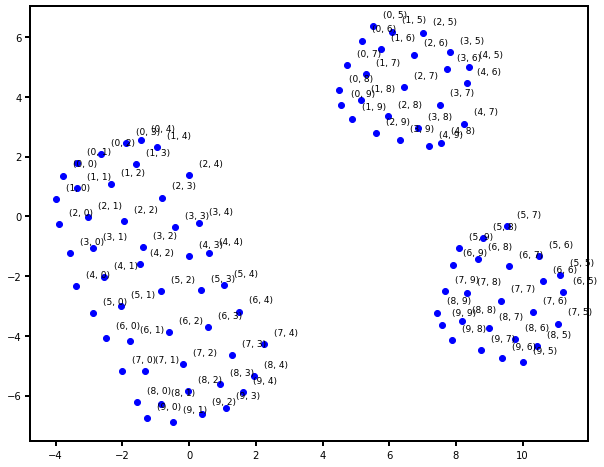

In [29]:
n2v_g = node2vec(g3, 20, 10)
g3_walks = n2v_g.get_walks()
w2v_m = Word2Vec(g3_walks, vector_size=50, window=10, min_count=1, sg=1, workers=1)
node_embeddings = w2v_m.wv.vectors
node_ids= w2v_m.wv.index_to_key

embs = tsne.fit_transform(node_embeddings)
plt.figure(figsize=(10,8))
for i,e in enumerate(node_ids):
    plt.scatter(embs[i,0], embs[i,1], color = 'b')
    plt.text(embs[i,0]+0.3, embs[i,1]+0.3, e, fontsize=9)
plt.show()

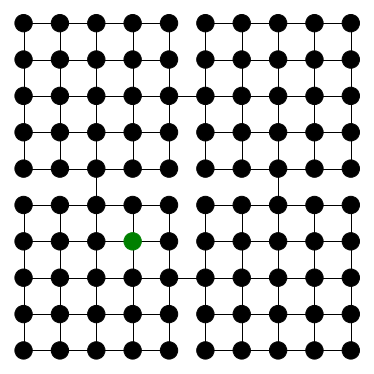

In [30]:
paint_nodes(g4, (6,3), False, [5,5])

In [31]:
g4.remove_edge((3,3), (2,3))

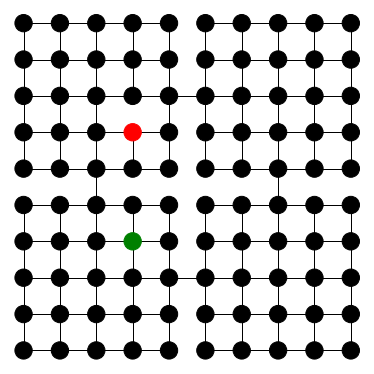

In [32]:
paint_nodes(g4, (6,3), (3,3), [5,5])

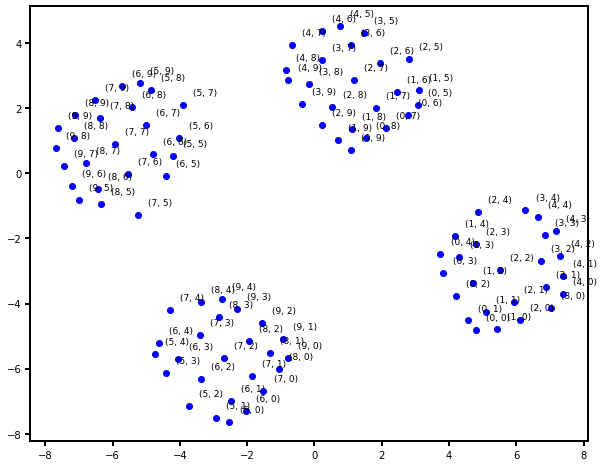

In [33]:
n2v_g = node2vec(g4, 20, 10)
g4_walks = n2v_g.get_walks()
w2v_m = Word2Vec(g4_walks, vector_size=50, window=10, min_count=1, sg=1, workers=1)
node_embeddings = w2v_m.wv.vectors
node_ids= w2v_m.wv.index_to_key

embs = tsne.fit_transform(node_embeddings)
plt.figure(figsize=(10,8))
for i,e in enumerate(node_ids):
    plt.scatter(embs[i,0], embs[i,1], color = 'b')
    plt.text(embs[i,0]+0.3, embs[i,1]+0.3, e, fontsize=9)
plt.show()

In [34]:
g5 = generate_connected_graphs(10, 1, 50, 50)
g5 = g5[0]

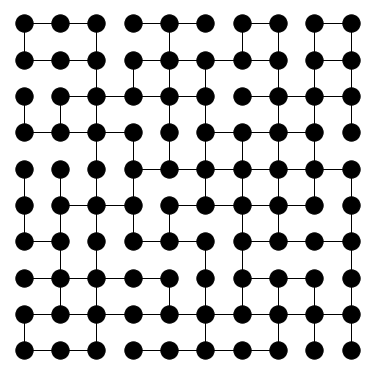

In [35]:
draw_graph(g5, [5,5])

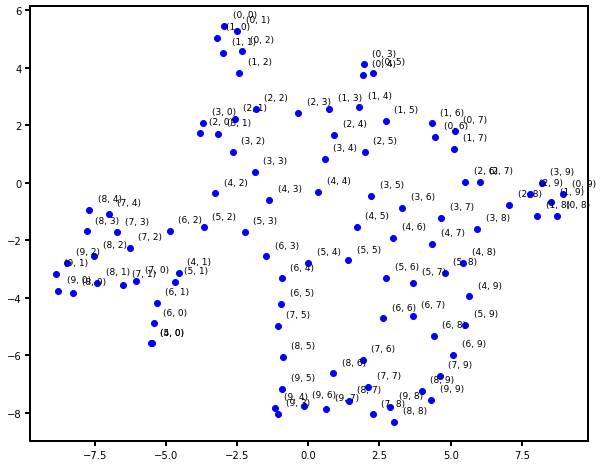

In [36]:
# get embeddings

n2v_g = node2vec(g5, 20, 10)
g5_walks = n2v_g.get_walks()
w2v_m = Word2Vec(g5_walks, vector_size=50, window=10, min_count=1, sg=1, workers=1)
node_embeddings = w2v_m.wv.vectors
node_ids= w2v_m.wv.index_to_key

embs = tsne.fit_transform(node_embeddings)
plt.figure(figsize=(10,8))
for i,e in enumerate(node_ids):
    plt.scatter(embs[i,0], embs[i,1], color = 'b')
    plt.text(embs[i,0]+0.3, embs[i,1]+0.3, e, fontsize=9)
plt.show()

In [37]:
len(g5.nodes)

100

In [38]:
np.asarray(g5_walks).shape

(2000, 10)

# Learning rules

$$V^h(s_t) = \sum_{i} \Gamma^\epsilon(s_t)_i <\phi_i,\mathbf{w}^h>$$

$$   \Gamma^\epsilon(s_t)_i = 
\begin{cases}
    0 & \text{if } ||\phi(s_t)-\phi_i||>\epsilon\\
     \frac{1}{1+\beta_V ||\phi(s_t)-\phi_i||},         & \text{otherwise}
\end{cases}$$

$$\delta^h_t = f^h(r_t) + \gamma V^h(s_{t+1})-V^h(s_t)$$

$$\mathcal{L}^h = ||\delta^h_t||^2$$

$$\frac{\partial \mathcal{L^h}}{\partial w^h_j} = 2 \delta^h_t\frac{\partial \delta^h_t}{\partial w^h_j}$$

$$\frac{\partial \delta_t}{\partial w^h_j} = \gamma\frac{\partial V^h(s_{t+1})}{\partial w^h_j} - \frac{\partial V^h(s_{t})}{\partial w^h_j} =   \sum_{i} \big ( \gamma \Gamma^\epsilon(s_{t+1})_i \phi_i-\Gamma^\epsilon(s_t)_i\phi_i \big )$$

$$\frac{\partial \mathcal{L^h}}{\partial w^h_j} = 2 \delta^h_t\sum_{i} \big ( \gamma \Gamma^\epsilon(s_{t+1})_i \phi_i-\Gamma^\epsilon(s_t)_i\phi_i \big )$$

$$w_j \leftarrow w_j + \alpha^h 2 \delta^h_t\sum_{i} \big ( \gamma \Gamma^\epsilon(s_{t+1})_i \phi_i-\Gamma^\epsilon(s_t)_i\phi_i \big )$$

$$\Gamma^\epsilon \in S^2$$

$$A^h(s,a) \leftarrow A^h(s,a) + \alpha \delta^h_t$$
$$A^T(s,a) = \sum_h \theta_h A^h(s,a)$$
$$\pi(a|s, \theta) = \frac{e^{\sum_h A^T(s,a)}}{\sum_a A^T(s,a)}$$

# calculate $\Gamma$ from embeddings

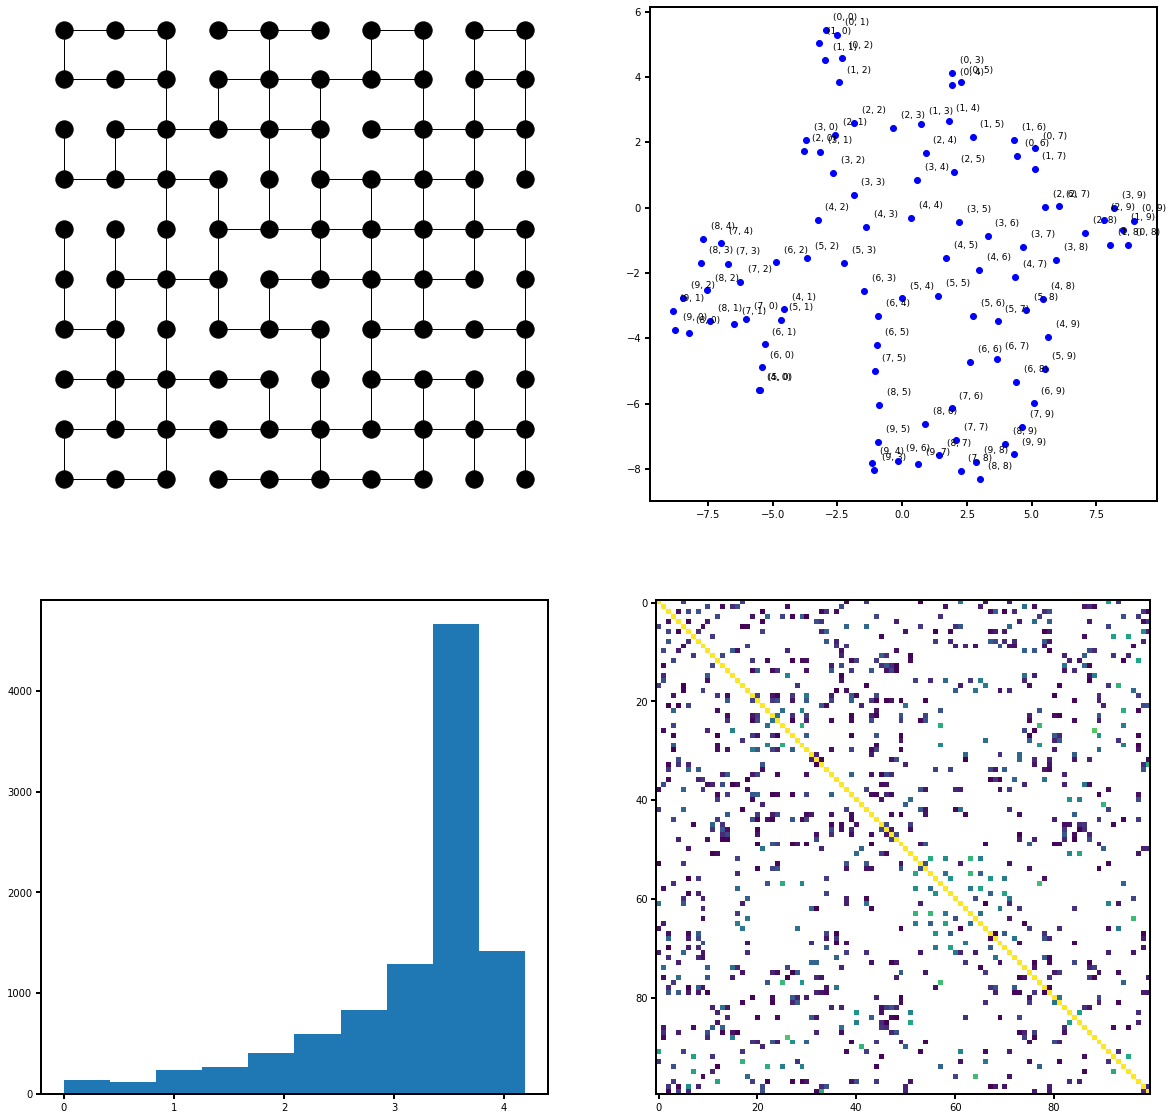

In [39]:
coords = node_embeddings
preGamma = distance.cdist(coords, coords, 'euclidean')
epsilon = 2
mask = preGamma < epsilon
Gamma = np.ma.masked_array(preGamma, (mask-1)*(-1))

# gamma, distances, embedding, histogram, maze
fig = plt.figure(figsize = [20,20])
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

G = g5
pos = {(x,y):(y,-x) for x,y in G.nodes()}
nx.draw(G, pos=pos,ax = ax1, 
        node_color='k', 
        with_labels=False,
        node_size=300)

for i,e in enumerate(node_ids):
    ax2.scatter(embs[i,0], embs[i,1], color = 'b')
    ax2.text(embs[i,0]+0.3, embs[i,1]+0.3, e, fontsize=9)

ax3.hist(preGamma.flatten())
beta = 1
realGamma = 1/(1 + beta * Gamma)
ax4.imshow(realGamma)

# next goals
* define RL environment
* code for update equations 
* learn one maze

In [40]:
# define reward - staying in the same place is penalised (?)

def get_next_state2(G, current_state, action, rwd, pun):
    # given an initial state, outputs the next state after action is taken
    # need to insert rewards/punishments (probably should be a data structure)
    rwd_state = rwd[0]
    rwd_mag = rwd[1]
    reward = 0
    t_flag = False # terminal flag
    
    pun_state = pun[0]
    pun_mag = pun[1]
    
    # get all edges of current_state node
    neigh_edges = G.edges(current_state)
    
    valid_state = False
    valid_transition = False
    
    if action == 0: #UP
        next_state = (current_state[0]-1, current_state[1])
    if action == 1: #DOWN
        next_state = (current_state[0]+1, current_state[1])    
    if action == 2: #LEFT
        next_state = (current_state[0], current_state[1]-1)    
    if action == 3: #RIGHT
        next_state = (current_state[0], current_state[1]+1)
        
    # check if next state is valid
    
    for node in G.nodes:
        if next_state == node:
            valid_state = True
    
    for edge in neigh_edges:
        if next_state == edge[1]:
            valid_transition = True
    
    if (valid_state & valid_transition):
        if next_state == rwd_state:
            reward = rwd_mag
        if next_state == pun_state:
            reward = pun_mag
        
        if reward != 0:
            t_flag = True
            
        return next_state, reward, t_flag
    else:
        reward = 0
        return current_state, reward, t_flag

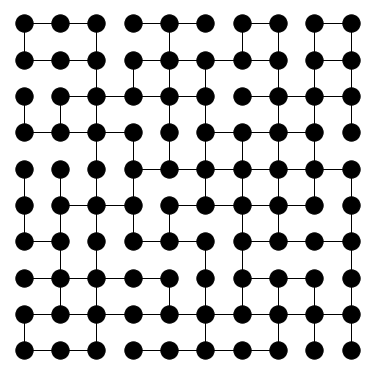

In [41]:
draw_graph(G, [5,5])

In [49]:
rwd = [(1,0), 10]
pun = [(0,1), -5]
cs = (0,0)
action = 0
ns, r, flag= get_next_state2(G, cs, action, rwd, pun)

# learn state value function - single critic
* define positive reward and run random agent
* define a set of negative rewards
* learn through the proximity matrix
* plot the value maps

In [50]:
rwd = [(9,9), 10]
pun = [(3,5), -5]
grid_size = 10
n_graphs = 1
n_tries = 1000
n_edges_removed = 3

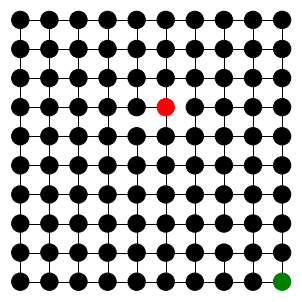

In [51]:
graph_l = generate_connected_graphs(grid_size, n_graphs, n_tries, n_edges_removed)
G = graph_l[0]
paint_nodes(G, rwd[0], pun[0], [4,4])

In [52]:
n_tries = 1000
n_steps = 100
cs = (0,0)
ns = (0,0)
action = 0
r_prev = 0

V = np.zeros((grid_size, grid_size))
gamma = 0.9
alpha = 0.01
for tr in range(n_tries):
    for k in range(n_steps):
        action = np.random.choice([0,1,2,3])
        ns, r, t_flag = get_next_state2(G, cs, action, rwd, pun)
        delta = r_prev + gamma * V[ns[0],ns[1]] - V[cs[0],cs[1]]
        V[cs[0],cs[1]] += alpha * delta
        cs = ns
        r_prev = r
        if t_flag:
            break

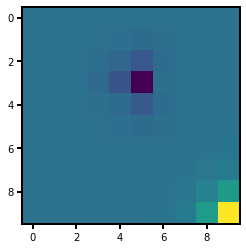

In [53]:
plt.imshow(V)

# learn multiple critics with different sensitivities

In [54]:
def nF(x, d):
    a = 0
    b = 1
    c = 3.7
    return a + b / (1 + c * np.exp(1 - d * x))

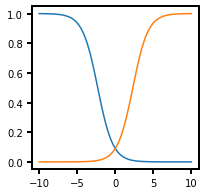

In [55]:
xv = np.linspace(-10,10,100)
plt.figure(figsize = [3,3])
plt.plot(xv, nF(xv, -1))
plt.plot(xv, nF(xv, 1))
plt.show()

In [56]:
rwd = [(9,9), 10]
pun = [(3,5), -5]
grid_size = 10
n_graphs = 1
n_tries = 1000
n_edges_removed = 3

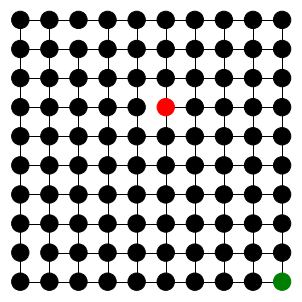

In [57]:
graph_l = generate_connected_graphs(grid_size, n_graphs, n_tries, n_edges_removed)
G = graph_l[0]
paint_nodes(G, rwd[0], pun[0], [4,4])

In [58]:
n_tries = 1000
n_steps = 50
cs = (0,0)
ns = (0,0)
action = 0
r_prev = 0

Vp = np.zeros((grid_size, grid_size))
Vn = np.zeros((grid_size, grid_size))
gamma = 1
alpha = 0.01
for tr in range(n_tries):
    for k in range(n_steps):
        
        action = np.random.choice([0,1,2,3])
        ns, r, t_flag = get_next_state2(G, cs, action, rwd, pun)
        
        delta_p = nF(r_prev,1) + gamma * Vp[ns[0],ns[1]] - Vp[cs[0],cs[1]]
        Vp[cs[0],cs[1]] += alpha * delta_p
        
        delta_n = nF(r_prev,-1) + gamma * Vn[ns[0],ns[1]] - Vn[cs[0],cs[1]]
        Vn[cs[0],cs[1]] += alpha * delta_n
        
        cs = ns
        r_prev = r
        if t_flag:
            break

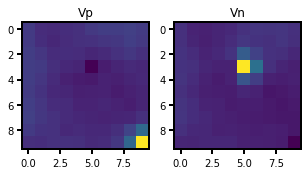

In [59]:
fig = plt.figure(figsize = [5,5])
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(Vp)
ax1.set_title('Vp')
ax2.imshow(Vn)
ax2.set_title('Vn')
plt.show()

## visualizing evoution of SR vectors
* also random walks, just build the transition matrix
* compare with node2vec
* make an animation of how the vectors are distributed

In [330]:
def generate_4_room_maze_v2(grid_size):
    n_tries = 1

    g1 = generate_connected_graphs(grid_size, 1, n_tries, 0)[0]    
    
    p1 = int(grid_size/2)
    p2 = int(grid_size/2)-1
    p3 = int((grid_size-1)/4)
    p4 = int(grid_size*3/4)
    print(p1,p2,p3,p4)
    
    for i in range(grid_size):
        g1.remove_edge((p1-1,i),(p1,i))
        g1.remove_edge((i,p1-1),(i,p1))
        
    g1.add_edge((p2,p3),(p1,p3))
    g1.add_edge((p3,p2),(p3,p1))
    g1.add_edge((p4,p2),(p4,p1))
    g1.add_edge((p2,p4),(p1,p4))
    
    return g1, grid_size

In [338]:
grid_size = 6

3 2 1 4


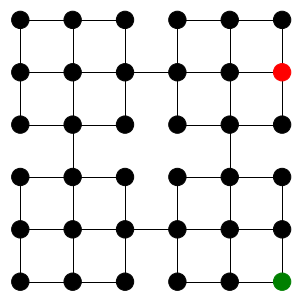

In [417]:
G, grid_size = generate_4_room_maze_v2(grid_size)
rwd = [(5,5), 10]
pun = [(1,5), -5]
paint_nodes(G, rwd[0], pun[0], [4,4])

In [343]:
def node2state(G, node):
    node_list = list(G.nodes)
    for i,e in enumerate(node_list):
        if e == node:
            return i

In [344]:
# defining an agent class
# want to check if the successor representation gives the same result
# random policy doesn't seem to work, but we also don't explore enough

class SuccessorAgent():
    def __init__(self, state_size, action_size, learning_rate, gamma):
        self.state_size = state_size
        self.action_size = action_size
        self.M = np.stack([np.identity(state_size) for i in range(action_size)])
        self.w = np.zeros([state_size])
        self.learning_rate = learning_rate
        self.gamma = gamma
        
    def onehot(self, value, max_value):
        vec = np.zeros(max_value)
        vec[value] = 1
        return vec

    def twohot(self, value, max_value):
        vec_1 = np.zeros(max_value)
        vec_2 = np.zeros(max_value)
        vec_1[value[0]] = 1
        vec_2[value[1]] = 1
        return np.concatenate([vec_1, vec_2])

    def mask_grid(self, grid, blocks, mask_value=-100):
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                if [i,j] in blocks:
                    grid[i,j] = mask_value
        grid = np.ma.masked_where(grid == mask_value, grid)
        return grid
        
    def Q_estimates(self, state, goal=None):
        # Generate Q values for all actions.
        if goal == None:
            goal = self.w
        else:
            goal = self.onehot(goal, self.state_size)
        return np.matmul(self.M[:,state,:],goal)
    
    def sample_action(self, state, goal=None, epsilon=0.0):
        # Samples action using epsilon-greedy approach
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(self.action_size)
        else:
            Qs = self.Q_estimates(state, goal)
            action = np.argmax(Qs)
        return action
    
    def update_w(self, current_exp):
        # A simple update rule
        s_1 = current_exp[2]
        r = current_exp[3]
        error = r - self.w[s_1]
        self.w[s_1] += self.learning_rate * error        
        return error
    
    # this part is a bit weirdly programmed
    def update_sr(self, current_exp, next_exp):
        # SARSA TD learning rule
        s = current_exp[0]
        s_a = current_exp[1]
        s_1 = current_exp[2]
        s_a_1 = next_exp[1]
        r = current_exp[3]
        d = current_exp[4]
        I = self.onehot(s, self.state_size)
        if d: #done     
            td_error = (I + self.gamma * self.onehot(s_1, self.state_size) - self.M[s_a, s, :])
        else: # not done
            td_error = (I + self.gamma * self.M[s_a_1, s_1, :] - self.M[s_a, s, :])
        self.M[s_a, s, :] += self.learning_rate * td_error
        
        return td_error

In [419]:
# generate state to index dictionary
node_list = list(G.nodes)
mSize = len(node_list)
n_actions = 4
gamma = 0.95
alpha = 0.01
epsilon_tr = 1

agent = SuccessorAgent(mSize, n_actions, alpha, gamma)

In [430]:
n_tries = 1000
n_steps = 500
cs = (0,0)
ns = (0,0)

action = 0
r_prev = 0

# defining SR matrices (outside agent class)
M = np.zeros((n_actions, mSize, mSize))
M1 = np.zeros((n_actions, mSize, mSize))
state_visits = np.zeros((grid_size, grid_size))

init_states = [(0,0),(9,0),(0,9),(9,9)]
pr = [0.25, 0.25, 0.25, 0.25]

episodic_error = []
td_hist = []
experiences = []
cs_st = 0

for tr in range(n_tries):
    #cs = random.choices(v, weights=pr)[0]
    cs = (0,0)
    for k in range(n_steps):
        
        action = agent.sample_action(cs_st, epsilon = epsilon_tr)
        
        ns, reward, t_flag = get_next_state2(G, cs, action, rwd, pun)
        
        # mapping graph id to state
        ns_st = node2state(G, ns)
        cs_st = node2state(G, cs)
        
        # training agent
        #print([cs_st, action, ns_st, reward, t_flag])
        experiences.append([cs_st, action, ns_st, reward, t_flag])
        
        if (k > 1):
            td_sr = agent.update_sr(experiences[-2], experiences[-1])
            td_w = agent.update_w(experiences[-1])
            episodic_error.append(np.mean(np.abs(td_sr)))
        
        td_hist.append(td_w)
        #agent.
        # for j in range(mSize):
            #if ns_st == j: delta = 1
            #else: delta = 0
            #M[action,cs_st,j] += alpha * (delta + gamma * M[action,ns_st, j] - M[action,cs_st, j])
    
        state_visits[cs[0],cs[1]] += 1
        
        cs = ns
        r_prev = r
        if t_flag:
            td_sr = agent.update_sr(experiences[-1], experiences[-1])
            episodic_error.append(np.mean(np.abs(td_sr)))
            break

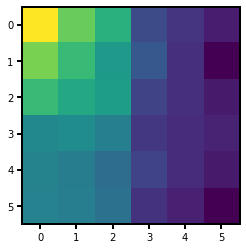

In [431]:
plt.imshow(state_visits)

In [432]:
def moving_average(a, n=1000) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

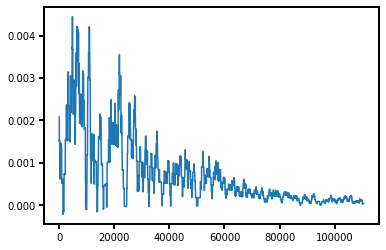

In [433]:
plt.plot(moving_average(td_hist))

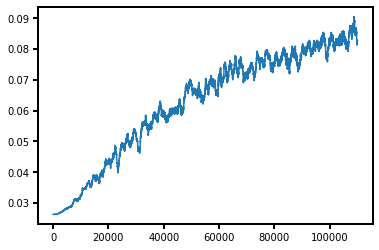

In [424]:
plt.plot(moving_average(episodic_error))

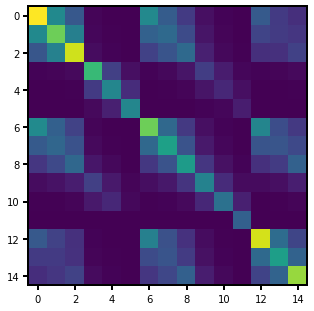

In [425]:
plt.figure(figsize = [5,10])
plt.imshow(np.mean(agent.M, axis = 0)[0:15,0:15])

In [426]:
a = np.zeros([agent.state_size])
for i in range(agent.state_size):
    Qs = agent.Q_estimates(i)
    V = np.mean(Qs)
    a[i] = V
V_Map = np.reshape(a, [grid_size, grid_size])
#V_Map = np.sqrt(V_Map)

#V_Map = agent.mask_grid(V_Map, env.blocks)

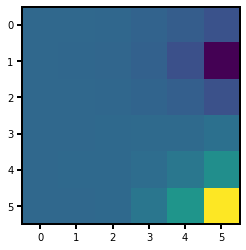

In [427]:
plt.imshow(V_Map)

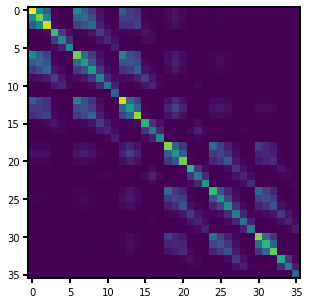

In [428]:
averaged_M = np.mean(agent.M, axis=0)
plt.figure(figsize = (5,5))
plt.imshow(averaged_M)

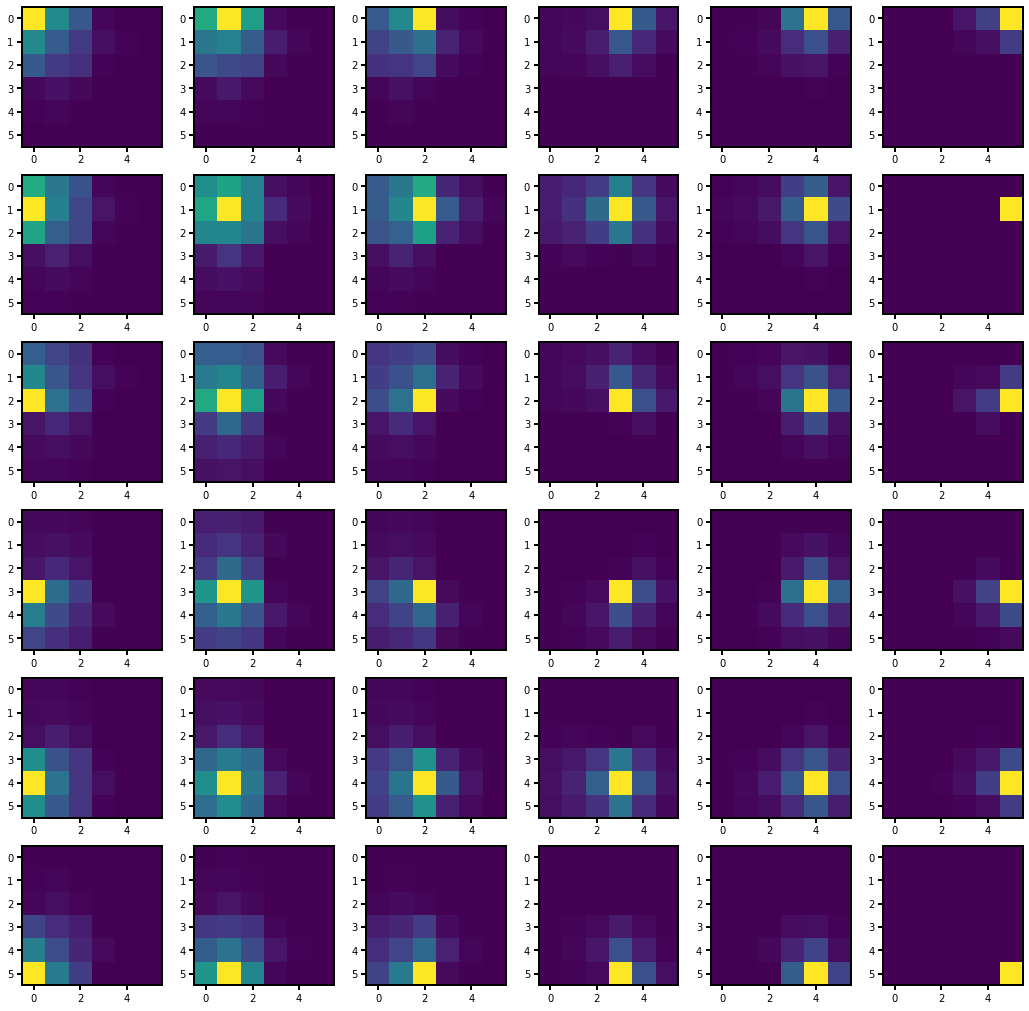

In [429]:
averaged_M = np.reshape(averaged_M, [agent.state_size, grid_size, grid_size])

cmap = plt.cm.viridis
cmap.set_bad(color='white')

plt.figure(1, figsize=(grid_size*3, grid_size*3))
for i in range(agent.state_size):
    ax = plt.subplot(grid_size, grid_size, i + 1)
    ax.imshow(averaged_M[i,:,:], cmap=cmap)

## check embedding (PCA, t-SNE)

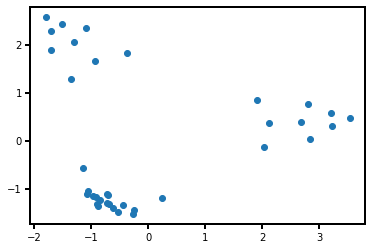

In [437]:
# only thing missing here is color coding the bottleneck states
M_s = np.mean(agent.M[:,:,:], axis=0)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(M_s[:])

plt.scatter(pca_result[:,0], pca_result[:,1])

## make test trajectories

## gridworld tests
* Q-learning, SARSA, Actor-critic
* split RL, tabular state space
* SR representation
* node2vec with split RL